In [1]:
# Enable autoreload extension
%load_ext autoreload
# Automatically reload all modules (except built-ins) before executing code
%autoreload 2

# Necessary

- Create VE
- Create dataset

In [35]:
import sys
import os
sys.path.append(os.path.abspath("/home/gdallagl/myworkdir/ESMSec/utils"))  # Adds current folder to Python path

import utils.my_functions as mf
import utils.models as my_models
import utils.dataset as my_dataset
import utils.embeddings_functions as my_embs

import torch
import torch.nn as nn
import random
import time
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import seaborn as sns

print(torch.__version__)

2.5.0+cu121


In [ ]:
# Configuration / hyperparameters
config = {
    "NUM_EPOCHS": 20,       # Total Epochs in training
    "EVAL_EPOCH_FREQ": 1,   # Evaluation frequency
    "BATCH_SIZE": 64,       # Batch size
    "LR": 5e-4,             # Learning rate
    "LR_DECAY_GAMMA": 0.5,    # Learning rate decay
    "LR_DECAY_STEPS_EPOCHS": 10, # Learning rate decay steps
    "SEED": 42,             # Random seed
    "PROTEIN_MAX_LENGTH": 1000, # Max protein length (for ESM2)
    "PRETRAIN_ESM_CHECKPOINT_NAME": "facebook/esm2_t6_8M_UR50D", # ESM2 model name
    "PRETRAIN_ESM_CACHE_DIR": "/home/gdallagl/myworkdir/data/esm2-models", # ESM2 model cache dir
    "DATASET_PATH": "/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/cell-cycle-dataset_2:3.csv", #"/home/gdallagl/myworkdir/ESMSec/data/protein/cyto_sec_dataset_claude.csv", # Path to dataset
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", # Device to use (cuda or cpu)
    "PATH_TO_SAVE_MODEL": "/home/gdallagl/myworkdir/ESMSec/data/trained_models/cell_cycle_trained_model.pth", # Path to save the model
    "TYPE_HEAD": "MLP",
    "TYPE_EMB_FOR_CLASSIFICATION": "contextualized_embs",
    "FROM_PRECOMPUTED_EMBS": False,
    "PRECOMPUTED_EMBS_DIM": 16
}

# Initializations
random.seed(config["SEED"])
np.random.seed(config["SEED"])
torch.manual_seed(config["SEED"])
torch.backends.cudnn.benchmark = True 

### Instantiate the model

In [61]:
# Load pre-trained ESM model
esm_model = AutoModel.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"],  cache_dir=config["PRETRAIN_ESM_CACHE_DIR"])
# Checj whcih model has been moded by AutoModel.from_pretrained()
print("\nESM model type", type(esm_model), "\n")

# Load relative tokenizer
tokenizer = AutoTokenizer.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"])

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ESM model type <class 'transformers.models.esm.modeling_esm.EsmModel'> 



In [62]:
# initialise model (ESM+ HEad)
net = my_models.EsmDeepSec(esm_model, 
                           type_head=config["TYPE_HEAD"],
                           type_emb_for_classification=config["TYPE_EMB_FOR_CLASSIFICATION"],
                           from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"],
                           precomputed_embs_dim=config["PRECOMPUTED_EMBS_DIM"]
                           ).to(config["DEVICE"])
# hidden dim of final embeggin of each aa after trnafoerm 
print(net.class_head)

# Block ESM paramters to be trained
if net.esm_model is not None:
    print("\nESM hidden dim", net.ESM_hidden_dim, "\n")
    for param in net.esm_model.parameters():
        param.requires_grad = False

MLPHead(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=1280, bias=True)
    (1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1280, out_features=628, bias=True)
    (5): LayerNorm((628,), eps=1e-05, elementwise_affine=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=628, out_features=32, bias=True)
    (9): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (10): ReLU()
    (11): Linear(in_features=32, out_features=2, bias=True)
  )
)

ESM hidden dim 2 



### Load dataset

In [63]:
# Load dataset
data = pd.read_csv(config["DATASET_PATH"])

# Preprocess each sequence individually
preprocessed_data = []
for idx, row in tqdm(data.iterrows(), total=len(data)):
    processed = my_dataset.preprocess_sequence(
        sequence=row['sequence'],
        label=row['label'],
        protein_name=row['protein'],
        tokenizer=tokenizer,
        protein_max_length=config["PROTEIN_MAX_LENGTH"]
    )
    preprocessed_data.append(processed)

# Create DataFrame from preprocessed data
processed_df = pd.DataFrame(preprocessed_data)

# Add the 'set' column back from original data
processed_df['set'] = data['set'].values
processed_df['embedding'] = data['embedding'].values

processed_df.head(5)

  0%|          | 0/5357 [00:00<?, ?it/s]

100%|██████████| 5357/5357 [00:10<00:00, 514.38it/s] 


,sequence,trunc_sequence,input_ids,attention_mask,label,protein,sequence_length,trunc_sequence_length,inputs_ids_length,inputs_ids_length_no_pad,set,embedding
0,MPSDKTIGGGDDSFNTFFSETGAGKHVPRAVFVDLEPTVIDEVRTGTYR,MPSDKTIGGGDDSFNTFFSETGAGKHVPRAVFVDLEPTVIDEVRTGTYR,"[tensor(0), tensor(20), tensor(14), tensor(8),...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,F8VRK0,49,49,1000,51,val,"tensor([0., 0., 0.])"
1,MWPTRRLVTIKRSGVDGPHFPLSLSTCLFGRGIECDIRIQLPVVSK...,MWPTRRLVTIKRSGVDGPHFPLSLSTCLFGRGIECDIRIQLPVVSK...,"[tensor(0), tensor(20), tensor(22), tensor(14)...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,P46013,3256,1000,1000,1000,val,"tensor([0., 0., 0.])"
2,MSWALEEWKEGLPTRALQKIQELEGQLDKLKKEKQQRQFQLDSLEA...,MSWALEEWKEGLPTRALQKIQELEGQLDKLKKEKQQRQFQLDSLEA...,"[tensor(0), tensor(20), tensor(8), tensor(22),...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,A0A9L9PXU7,3055,1000,1000,1000,train,"tensor([0., 0., 0.])"
3,MAEEGAVAVCVRVRPLNSREESLGETAQVYWKTDNNVIYQVDGSKS...,MAEEGAVAVCVRVRPLNSREESLGETAQVYWKTDNNVIYQVDGSKS...,"[tensor(0), tensor(20), tensor(5), tensor(9), ...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,Q02224,2701,1000,1000,1000,train,"tensor([0., 0., 0.])"
4,MGDDSEWLKLPVDQKCEHKLWKARLSGYEEALKIFQKIKDEKSPEW...,MGDDSEWLKLPVDQKCEHKLWKARLSGYEEALKIFQKIKDEKSPEW...,"[tensor(0), tensor(20), tensor(6), tensor(13),...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,Q14008,2032,1000,1000,1000,train,"tensor([0., 0., 0.])"


In [ ]:
   
    #  # OPTIONAL: ADD PRECOMPUTED EMBEDDINGS
    # def generate_noise(row, mean_1 = 1, mean_0 = -1, sigma = 1, embedding_dim = config["PRECOMPUTED_EMBS_DIM"]):
    #     mean = mean_1 if row['label'] == 1 else mean_0
    #     return torch.randn(embedding_dim) * sigma + mean
    # processed_df["embedding"] = processed_df.apply(generate_noise, axis=1)

    # # inspect the DataFrame
    # display(processed_df.head(5))
    # print(processed_df.loc[0, "input_ids"])

,sequence,trunc_sequence,input_ids,attention_mask,label,protein,sequence_length,trunc_sequence_length,inputs_ids_length,inputs_ids_length_no_pad,set,embedding
0,MPSDKTIGGGDDSFNTFFSETGAGKHVPRAVFVDLEPTVIDEVRTGTYR,MPSDKTIGGGDDSFNTFFSETGAGKHVPRAVFVDLEPTVIDEVRTGTYR,"[tensor(0), tensor(20), tensor(14), tensor(8),...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,F8VRK0,49,49,1000,51,val,"[tensor(1.6569), tensor(-0.6431)]"
1,MWPTRRLVTIKRSGVDGPHFPLSLSTCLFGRGIECDIRIQLPVVSK...,MWPTRRLVTIKRSGVDGPHFPLSLSTCLFGRGIECDIRIQLPVVSK...,"[tensor(0), tensor(20), tensor(22), tensor(14)...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,P46013,3256,1000,1000,1000,val,"[tensor(2.3855), tensor(1.2893)]"
2,MSWALEEWKEGLPTRALQKIQELEGQLDKLKKEKQQRQFQLDSLEA...,MSWALEEWKEGLPTRALQKIQELEGQLDKLKKEKQQRQFQLDSLEA...,"[tensor(0), tensor(20), tensor(8), tensor(22),...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,A0A9L9PXU7,3055,1000,1000,1000,train,"[tensor(0.1602), tensor(0.9710)]"
3,MAEEGAVAVCVRVRPLNSREESLGETAQVYWKTDNNVIYQVDGSKS...,MAEEGAVAVCVRVRPLNSREESLGETAQVYWKTDNNVIYQVDGSKS...,"[tensor(0), tensor(20), tensor(5), tensor(9), ...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,Q02224,2701,1000,1000,1000,train,"[tensor(1.2271), tensor(-0.6249)]"
4,MGDDSEWLKLPVDQKCEHKLWKARLSGYEEALKIFQKIKDEKSPEW...,MGDDSEWLKLPVDQKCEHKLWKARLSGYEEALKIFQKIKDEKSPEW...,"[tensor(0), tensor(20), tensor(6), tensor(13),...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,Q14008,2032,1000,1000,1000,train,"[tensor(1.1331), tensor(0.3398)]"


tensor([ 0, 20, 14,  8, 13, 15, 11, 12,  6,  6,  6, 13, 13,  8, 18, 17, 11, 18,
        18,  8,  9, 11,  6,  5,  6, 15, 21,  7, 14, 10,  5,  7, 18,  7, 13,  4,
         9, 14, 11,  7, 12, 13,  9,  7, 10, 11,  6, 11, 19, 10,  2,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1, 

In [67]:
############################################
# processed_df = (
#     processed_df.groupby("set", group_keys=False)
#       .apply(lambda x: x.sample(frac=0.25, random_state=42))
#       .reset_index(drop=True)
# )
# display(processed_df)
############################################

# ATTENTION: the name of the cols in the df must be speicifc
train_dl = my_dataset.create_dataloader(processed_df, 'train', config["BATCH_SIZE"], shuffle=True)
valid_dl = my_dataset.create_dataloader(processed_df, 'val', config["BATCH_SIZE"], shuffle=False)
test_dl = my_dataset.create_dataloader(processed_df, 'test', config["BATCH_SIZE"], shuffle=False)


<Axes: >

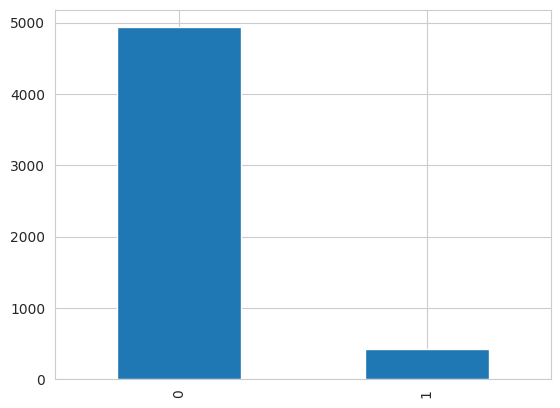

In [68]:
processed_df["label"].value_counts().reset_index(drop="True").plot(kind='bar')

### Define weighted loss fucntion

In [69]:
# With weighted loss:
class_counts = list(processed_df[processed_df.set == "train"].label.value_counts())
print(class_counts)
class_weights = torch.tensor([1.0 / class_counts[0], 1.0 / class_counts[1]])
class_weights = class_weights / class_weights.sum()  # normalize
class_weights = class_weights.to(config["DEVICE"])

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

[3947, 338]


### Train

In [70]:
#results = mf.train(net, train_dl, valid_dl, test_dl, loss_fn, config)
results = mf.train(net, train_dl, valid_dl, test_dl, loss_fn, config, from_precomputed_embs=True) # precomputed are in the dataloder

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 1 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2277, Acc: 92.67%, Balanced Acc: 92.64%, F1: 0.6660, MCC: 0.6615


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2262, Acc: 92.91%, Balanced Acc: 92.96%, F1: 0.6780, MCC: 0.6728


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:   5%|▌         | 1/20 [00:00<00:12,  1.50epoch/s]

	Test set: Loss: 0.2408, Acc: 92.35%, Balanced Acc: 92.58%, F1: 0.6555, MCC: 0.6525
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 1, New LR: 0.0005


Epoch 2:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 2 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2137, Acc: 93.16%, Balanced Acc: 92.64%, F1: 0.6798, MCC: 0.6734


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2046, Acc: 92.91%, Balanced Acc: 92.96%, F1: 0.6780, MCC: 0.6728


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  10%|█         | 2/20 [00:01<00:12,  1.44epoch/s]

	Test set: Loss: 0.2164, Acc: 92.91%, Balanced Acc: 92.89%, F1: 0.6724, MCC: 0.6682
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 2, New LR: 0.0005


Epoch 3:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 3 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2190, Acc: 90.90%, Balanced Acc: 92.08%, F1: 0.6184, MCC: 0.6194


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2667, Acc: 90.86%, Balanced Acc: 93.97%, F1: 0.6316, MCC: 0.6391


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  15%|█▌        | 3/20 [00:02<00:11,  1.49epoch/s]

	Test set: Loss: 0.2792, Acc: 90.30%, Balanced Acc: 91.47%, F1: 0.6000, MCC: 0.6017
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 3, New LR: 0.0005


Epoch 4:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 4 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2136, Acc: 93.93%, Balanced Acc: 92.11%, F1: 0.7005, MCC: 0.6895


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.1826, Acc: 93.84%, Balanced Acc: 92.41%, F1: 0.7027, MCC: 0.6922


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  20%|██        | 4/20 [00:02<00:10,  1.53epoch/s]

	Test set: Loss: 0.2007, Acc: 93.66%, Balanced Acc: 93.29%, F1: 0.6964, MCC: 0.6905
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 4, New LR: 0.0005


Epoch 5:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 5 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2051, Acc: 92.23%, Balanced Acc: 92.67%, F1: 0.6542, MCC: 0.6517


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2227, Acc: 90.86%, Balanced Acc: 91.85%, F1: 0.6202, MCC: 0.6194


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  25%|██▌       | 5/20 [00:03<00:09,  1.51epoch/s]

	Test set: Loss: 0.2349, Acc: 91.98%, Balanced Acc: 93.47%, F1: 0.6504, MCC: 0.6523
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 5, New LR: 0.0005


Epoch 6:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 6 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2071, Acc: 92.44%, Balanced Acc: 92.65%, F1: 0.6597, MCC: 0.6562


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2240, Acc: 92.72%, Balanced Acc: 92.86%, F1: 0.6723, MCC: 0.6675


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  30%|███       | 6/20 [00:03<00:09,  1.52epoch/s]

	Test set: Loss: 0.2414, Acc: 91.79%, Balanced Acc: 92.28%, F1: 0.6393, MCC: 0.6377
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 6, New LR: 0.0005


Epoch 7:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 7 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2050, Acc: 90.88%, Balanced Acc: 92.21%, F1: 0.6185, MCC: 0.6201


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2526, Acc: 90.11%, Balanced Acc: 92.50%, F1: 0.6074, MCC: 0.6124


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  35%|███▌      | 7/20 [00:04<00:08,  1.51epoch/s]

	Test set: Loss: 0.2716, Acc: 90.11%, Balanced Acc: 92.46%, F1: 0.6015, MCC: 0.6078
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 7, New LR: 0.0005


Epoch 8:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 8 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2081, Acc: 93.91%, Balanced Acc: 92.09%, F1: 0.6997, MCC: 0.6887


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.1864, Acc: 93.66%, Balanced Acc: 93.37%, F1: 0.7018, MCC: 0.6950


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  40%|████      | 8/20 [00:05<00:08,  1.47epoch/s]

	Test set: Loss: 0.1991, Acc: 93.66%, Balanced Acc: 92.20%, F1: 0.6909, MCC: 0.6815
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 8, New LR: 0.0005


Epoch 9:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 9 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2121, Acc: 90.62%, Balanced Acc: 92.20%, F1: 0.6127, MCC: 0.6154


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2628, Acc: 89.55%, Balanced Acc: 92.20%, F1: 0.5942, MCC: 0.6003


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  45%|████▌     | 9/20 [00:06<00:07,  1.47epoch/s]

	Test set: Loss: 0.2821, Acc: 89.93%, Balanced Acc: 93.45%, F1: 0.6029, MCC: 0.6140
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 9, New LR: 0.0005


Epoch 10:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 10 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2029, Acc: 93.16%, Balanced Acc: 92.23%, F1: 0.6777, MCC: 0.6699


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2050, Acc: 93.47%, Balanced Acc: 93.27%, F1: 0.6957, MCC: 0.6893


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  50%|█████     | 10/20 [00:06<00:06,  1.50epoch/s]

	Test set: Loss: 0.2268, Acc: 92.91%, Balanced Acc: 92.89%, F1: 0.6724, MCC: 0.6682
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 10, New LR: 0.00025


Epoch 11:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 11 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2015, Acc: 91.67%, Balanced Acc: 92.37%, F1: 0.6383, MCC: 0.6371


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2367, Acc: 89.93%, Balanced Acc: 91.34%, F1: 0.5970, MCC: 0.5982


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  55%|█████▌    | 11/20 [00:07<00:05,  1.53epoch/s]

	Test set: Loss: 0.2561, Acc: 90.67%, Balanced Acc: 92.76%, F1: 0.6154, MCC: 0.6204
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 11, New LR: 0.00025


Epoch 12:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 12 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2004, Acc: 92.88%, Balanced Acc: 92.48%, F1: 0.6710, MCC: 0.6652


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2106, Acc: 93.28%, Balanced Acc: 93.16%, F1: 0.6897, MCC: 0.6837


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  60%|██████    | 12/20 [00:07<00:05,  1.50epoch/s]

	Test set: Loss: 0.2252, Acc: 92.91%, Balanced Acc: 92.89%, F1: 0.6724, MCC: 0.6682
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 12, New LR: 0.00025


Epoch 13:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 13 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1968, Acc: 92.98%, Balanced Acc: 92.40%, F1: 0.6732, MCC: 0.6667


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2075, Acc: 93.10%, Balanced Acc: 93.06%, F1: 0.6838, MCC: 0.6782


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  65%|██████▌   | 13/20 [00:08<00:04,  1.53epoch/s]

	Test set: Loss: 0.2249, Acc: 92.16%, Balanced Acc: 92.48%, F1: 0.6500, MCC: 0.6475
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 13, New LR: 0.00025


Epoch 14:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 14 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1963, Acc: 92.98%, Balanced Acc: 92.53%, F1: 0.6739, MCC: 0.6679


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2039, Acc: 93.28%, Balanced Acc: 93.16%, F1: 0.6897, MCC: 0.6837


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  70%|███████   | 14/20 [00:09<00:03,  1.54epoch/s]

	Test set: Loss: 0.2180, Acc: 93.10%, Balanced Acc: 92.99%, F1: 0.6783, MCC: 0.6736
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 14, New LR: 0.00025


Epoch 15:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 15 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2034, Acc: 91.34%, Balanced Acc: 92.19%, F1: 0.6294, MCC: 0.6289


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2426, Acc: 89.93%, Balanced Acc: 91.34%, F1: 0.5970, MCC: 0.5982


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  75%|███████▌  | 15/20 [00:09<00:03,  1.52epoch/s]

	Test set: Loss: 0.2572, Acc: 90.67%, Balanced Acc: 93.85%, F1: 0.6212, MCC: 0.6305
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 15, New LR: 0.00025


Epoch 16:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 16 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1964, Acc: 92.86%, Balanced Acc: 92.74%, F1: 0.6717, MCC: 0.6668


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2150, Acc: 92.72%, Balanced Acc: 92.86%, F1: 0.6723, MCC: 0.6675


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  80%|████████  | 16/20 [00:10<00:02,  1.53epoch/s]

	Test set: Loss: 0.2332, Acc: 92.35%, Balanced Acc: 92.58%, F1: 0.6555, MCC: 0.6525
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 16, New LR: 0.00025


Epoch 17:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 17 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2002, Acc: 93.79%, Balanced Acc: 92.30%, F1: 0.6970, MCC: 0.6872


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.1871, Acc: 93.66%, Balanced Acc: 92.31%, F1: 0.6964, MCC: 0.6863


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  85%|████████▌ | 17/20 [00:11<00:02,  1.50epoch/s]

	Test set: Loss: 0.2025, Acc: 93.66%, Balanced Acc: 93.29%, F1: 0.6964, MCC: 0.6905
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 17, New LR: 0.00025


Epoch 18:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 18 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1980, Acc: 91.86%, Balanced Acc: 92.33%, F1: 0.6428, MCC: 0.6407


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2366, Acc: 91.42%, Balanced Acc: 93.21%, F1: 0.6406, MCC: 0.6427


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  90%|█████████ | 18/20 [00:12<00:01,  1.28epoch/s]

	Test set: Loss: 0.2518, Acc: 91.04%, Balanced Acc: 91.87%, F1: 0.6190, MCC: 0.6191
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 18, New LR: 0.00025


Epoch 19:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 19 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1953, Acc: 92.81%, Balanced Acc: 92.72%, F1: 0.6702, MCC: 0.6655


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2180, Acc: 92.91%, Balanced Acc: 92.96%, F1: 0.6780, MCC: 0.6728


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training:  95%|█████████▌| 19/20 [00:13<00:00,  1.32epoch/s]

	Test set: Loss: 0.2322, Acc: 92.35%, Balanced Acc: 92.58%, F1: 0.6555, MCC: 0.6525
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 19, New LR: 0.00025


Epoch 20:   0%|          | 0/67 [00:00<?, ?train batch/s]

--- Evaluation at iteration 20 ---


Evaluation:   0%|          | 0/67 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1960, Acc: 93.40%, Balanced Acc: 92.49%, F1: 0.6859, MCC: 0.6781


Evaluation:   0%|          | 0/9 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2004, Acc: 93.66%, Balanced Acc: 93.37%, F1: 0.7018, MCC: 0.6950


Evaluation:   0%|          | 0/9 [00:00<?, ? Test batch/s]

Training: 100%|██████████| 20/20 [00:13<00:00,  1.45epoch/s]

	Test set: Loss: 0.2162, Acc: 93.28%, Balanced Acc: 93.09%, F1: 0.6842, MCC: 0.6791
Allocated memory: 0.06 GB
Cached memory:    0.10 GB
Epoch 20, New LR: 0.000125


### Plot


                         FINAL EVALUATION METRICS
Metric                    Train      Validation            Test
--------------- --------------- --------------- ---------------
Loss                     0.1960          0.2004          0.2162
Accuracy                 93.40%          93.66%          93.28%
Balanced Acc             92.49%          93.37%          93.09%
F1 Score                 0.6859          0.7018          0.6842
MCC                      0.6781          0.6950          0.6791

                            PERFORMANCE ANALYSIS

✓ Good generalization (Train-Valid gap: -0.26%)
✓ Test-Valid gap: -0.37%

✓ Class distribution (Test): {0: np.int64(3947), 1: np.int64(338)}
⚠️  Class imbalance detected (ratio: 11.68:1)
   → Balanced accuracy is more reliable than accuracy


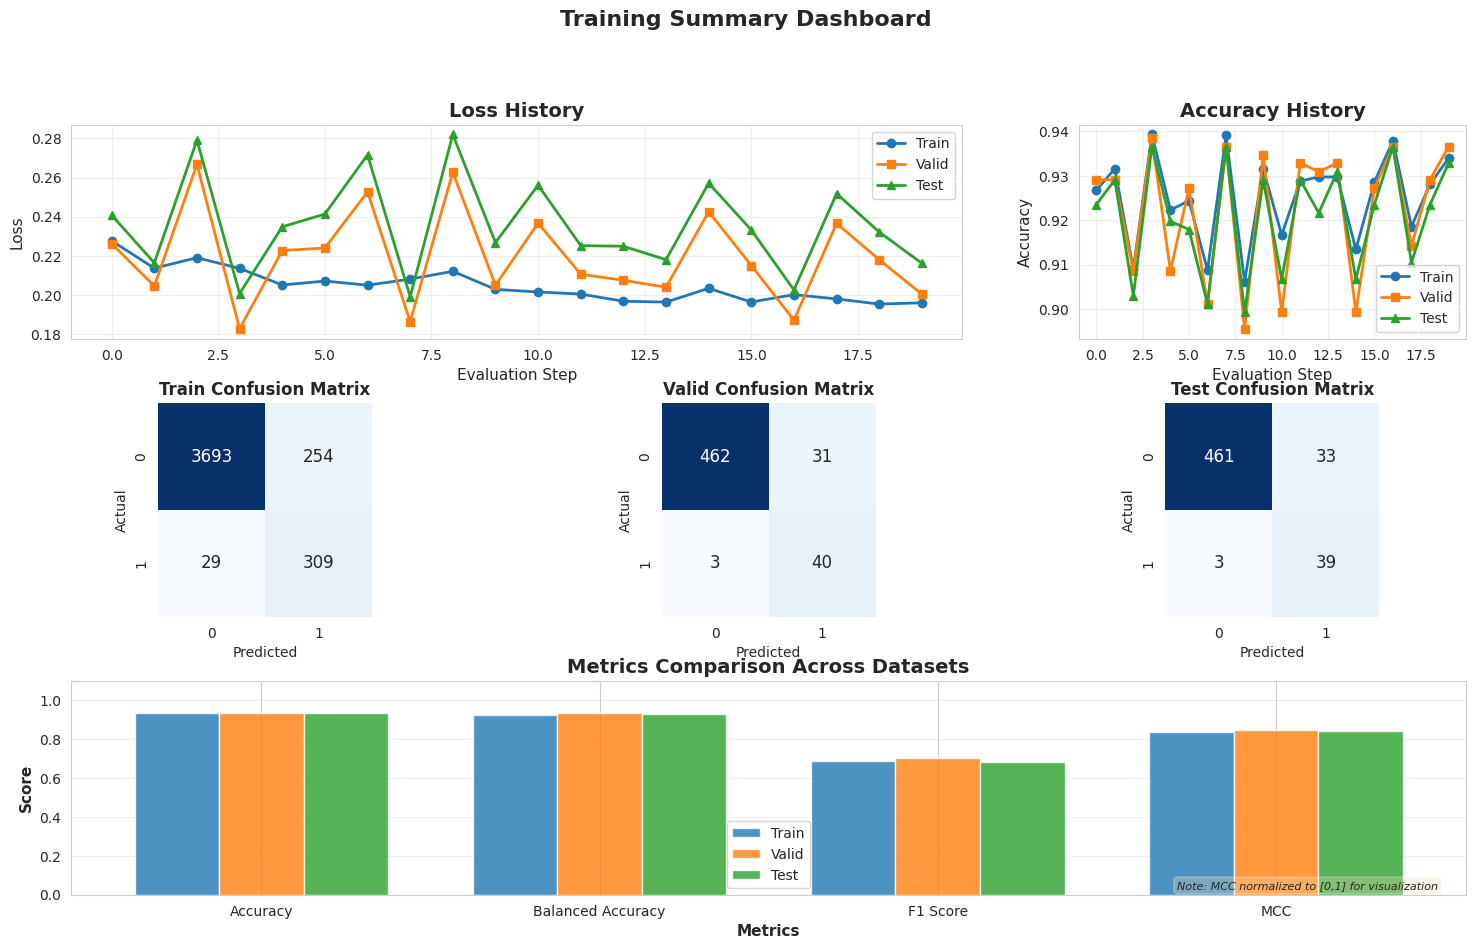


                         TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0     0.9935    0.9332    0.9624       494
     Class 1     0.5417    0.9286    0.6842        42

    accuracy                         0.9328       536
   macro avg     0.7676    0.9309    0.8233       536
weighted avg     0.9581    0.9328    0.9406       536




In [71]:
mf.summarize_training(*results)

### Save Model

In [ ]:
torch.save(net, config["PATH_TO_SAVE_MODEL"])

### Load Model

In [ ]:
net = torch.load(config["PATH_TO_SAVE_MODEL"])
net.eval()

/tmp/ipykernel_151039/3766833804.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(config["PATH_TO_SAVE_MODEL"])


EsmDeepSec(
  (esm_model): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_features=320, out_fe

### Umaps

Many types of embeddings can be extracted from different moments inside the model:

**1. From the ESM backbone**
- **ESM mean** → mean pooling over all token embeddings.  
- **ESM max** → max pooling over all token embeddings.  
- **ESM CLS** → embedding of the special classification token (first position).  
- **ESM tokens** → full sequence of token-level embeddings `[batch, seq_len, hidden_dim]`.  
- (Optional) **Layerwise embeddings** → extracting hidden states from multiple layers (e.g. last 4).

**2. From the feature head (AttentionClassificationHead)**
- **Feature mean** → mean pooling after attention + FFNN.  
- **Feature max** → max pooling after attention + FFNN.  
- **Feature CLS** → CLS token representation after attention + FFNN.  
- **Feature concat** → concatenation of mean and max pooling (used for classification).  


Extracting embeddings from training set...



Batch:   0%|          | 0/67 [00:00<?, ? batch/s]

All possbile embedding given current model architecrure:
precomputed_embs: (4285, 16)

Computing UMAP embeddings...

Computing UMAP for precomputed_embs with shape (4285, 16)...



Plotting UMAP embeddings...



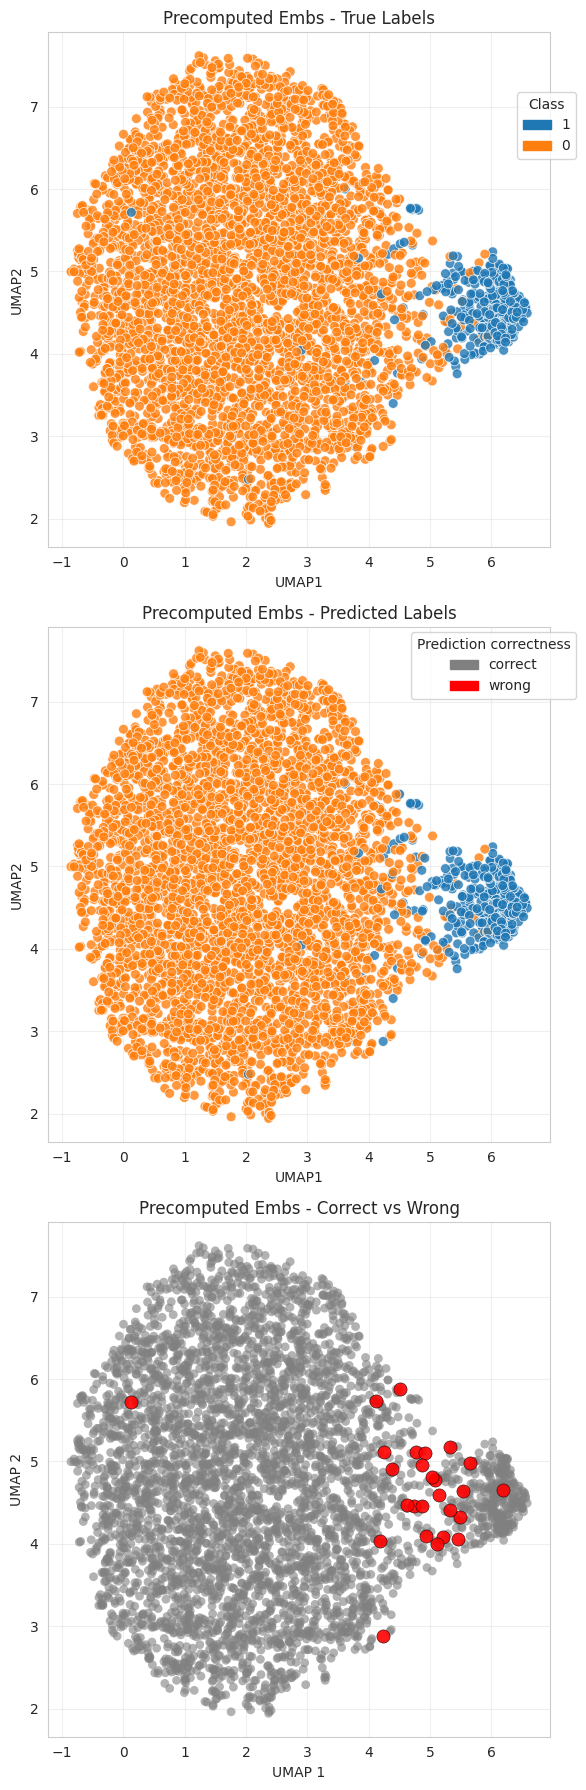

In [58]:
DATALOADER = train_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = my_embs.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    return_numpy=True, # set to False if you want torch tensors instead
    from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    print(f"{key}: {emb.shape}")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = my_embs.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

if len(list(train_embeddings)) != 0:
    df = my_embs.plot_umap_embeddings(umap_tensors, names, labels, predictions)
else:
    print("No embs to plot")


Extracting embeddings from training set...



All possbile embedding given current model architecrure:
precomputed_embs: (536, 2)

Computing UMAP embeddings...

Computing UMAP for precomputed_embs with shape (536, 2)...



Plotting UMAP embeddings...



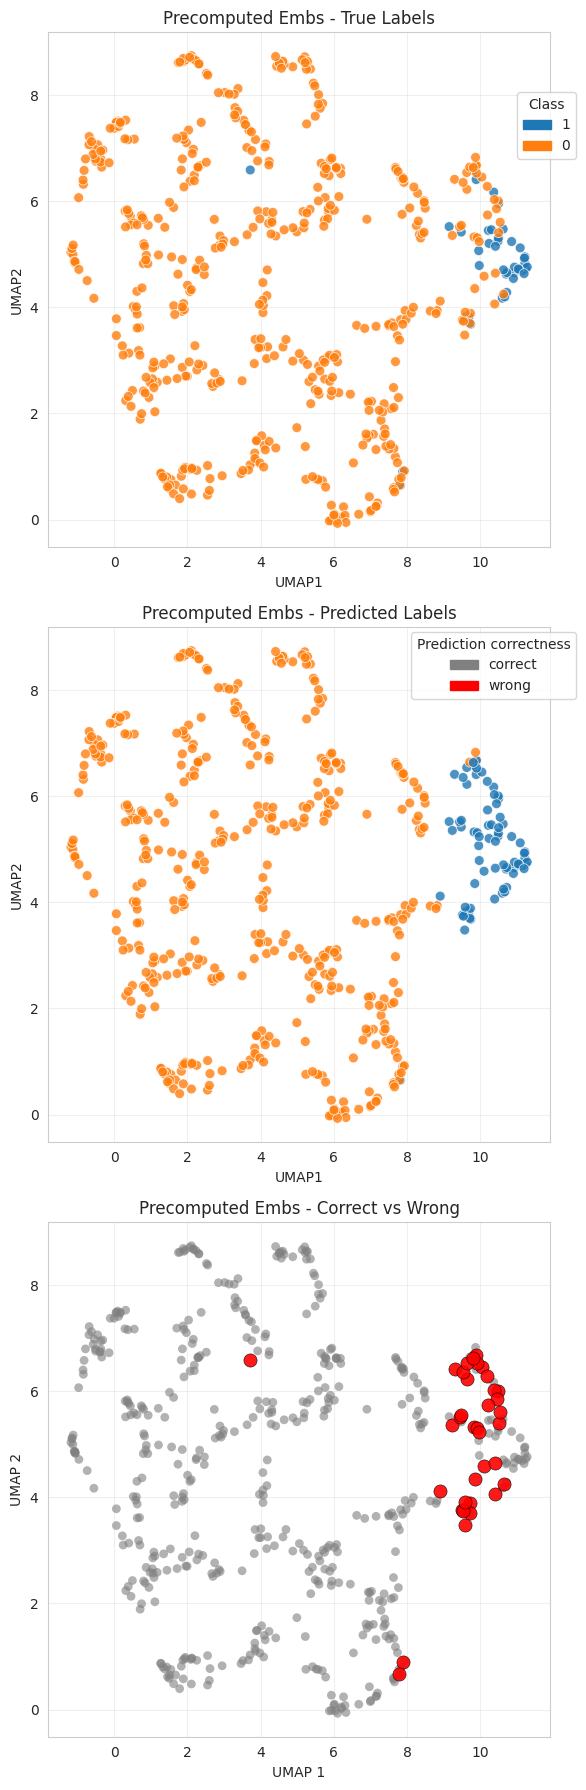

In [72]:
DATALOADER = test_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = my_embs.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    return_numpy=True, # set to False if you want torch tensors instead
    from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    print(f"{key}: {emb.shape}")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = my_embs.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

if len(list(train_embeddings)) != 0:
    df = my_embs.plot_umap_embeddings(umap_tensors, names, labels, predictions)
else:
    print("No embs to plot")

In [ ]:
df = df["esm_mean"]
df[(df["CorrectStr"] == "correct") & (df["TrueClass"] == "1")]

#df[df['CorrectStr'] == 'correct']


,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr
0,J3QKX0,2.084181,7.610769,1,1,correct
2,P33981,2.231934,7.498143,1,1,correct
3,A0A3B3ITP6,3.285445,7.148716,1,1,correct
4,B0QZD0,7.625128,4.741978,1,1,correct
7,A0A6Q8PFD2,5.149831,5.900741,1,1,correct
8,P14635,5.129323,6.119648,1,1,correct
10,A0A7P0SBL1,5.428132,6.623245,1,1,correct
11,H1UBN3,5.929316,6.196060,1,1,correct
12,Q5T2Z0,4.958824,4.179790,1,1,correct
13,F8VNY2,5.228599,6.597728,1,1,correct


### A-scanning

sequence                    MSSMWSEYTIGGVKIYFPYKAYPSQLAMMNSILRGLNSKQHCLLES...
trunc_sequence              MSSMWSEYTIGGVKIYFPYKAYPSQLAMMNSILRGLNSKQHCLLES...
input_ids                   [tensor(0), tensor(20), tensor(8), tensor(8), ...
attention_mask              [tensor(1), tensor(1), tensor(1), tensor(1), t...
label                                                                       1
protein                                                                J3QKX0
sequence_length                                                           852
trunc_sequence_length                                                     852
inputs_ids_length                                                        1000
inputs_ids_length_no_pad                                                  854
set                                                                      test
Name: 41, dtype: object

5


Evaluation:   0%|          | 0/1 [00:00<?, ? Single protein batch/s]

Generating mutations:   0%|          | 0/852 [00:00<?, ?it/s]

Preprocessing mutations:   0%|          | 0/3408 [00:00<?, ?it/s]

Evaluating model on mutated sequences...


Evaluation:   0%|          | 0/101 [00:00<?, ? Multi-AA Scan batch/s]

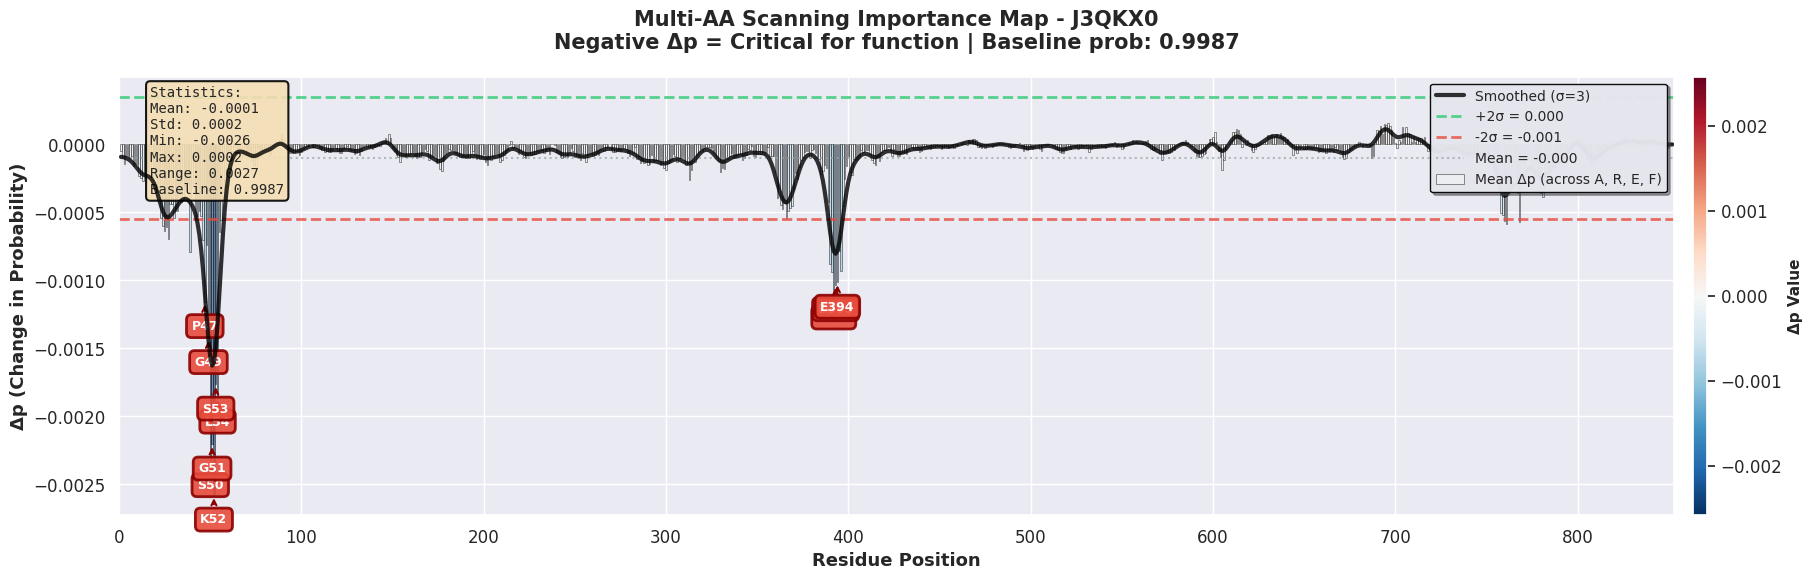


                      MULTI-AA SCANNING SUMMARY                       

Sequence Information:         
  Length:                   852
  Protein:                  J3QKX0
  Substitute AAs:           A, R, E, F
  Baseline Probability:     0.9987

Statistical Summary:          
  Mean Δp:                  -0.0001
  Std Δp:                   0.0002
  Min Δp:                   -0.0026
  Max Δp:                   0.0002
  Threshold (+2σ):          0.0004
  Threshold (-2σ):          -0.0005

──────────────────────────────────────────────────────────────────────
             TOP CRITICAL RESIDUES (Largest Negative Δp)              
──────────────────────────────────────────────────────────────────────
Rank    Position    Residue     Δp             Status              
──────────────────────────────────────────────────────────────────────
1       52          K           -0.0026        ⚠️  Beyond threshold
2       50          S           -0.0023        ⚠️  Beyond threshold
3       51          G

In [ ]:
PROTEIN = df[(df["CorrectStr"] == "correct") & (df["TrueClass"] == "1")].iloc[0].Name
#"A0A8V8TKW5" #"P39039" # "Q91VU0"
WINDOW_SIZE_FRACTION = 0.01 # 10% of sequence length
SUBSTITUTE_AA = "A" #"<pad>", "A", "P"

# Extract info
single_protein_info = processed_df[processed_df['protein'] == PROTEIN].iloc[0]
display(single_protein_info)

WINDOW_SIZE_SUBSTITUION = 5 #int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd
print(WINDOW_SIZE_SUBSTITUION)

scan_results = mf.multi_aa_scanning(net, tokenizer, 
                      single_protein_info, 
                      window_size=WINDOW_SIZE_SUBSTITUION, 
                      substitute_aas=["A", "R", "E", "F"],
                      normalise_true_substitution=False,
                      device=config["DEVICE"])

mf.plot_multi_aa_scan(scan_results, show_per_aa=False)

# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

### A-scanning Logits

In [ ]:
def prob_to_logit(p):
    """
    Convert probability of class 1 to logit (binary case)
    p: float or np.array of probabilities (0 < p < 1)
    returns: logit value(s)
    """
    p = np.clip(p, 1e-15, 1 - 1e-15)  # avoid log(0)
    return np.log(p / (1 - p))


PROTEIN = "P05997" #"Q6ZRI0" #"P01270" #"O60938" #"P05997"
WINDOW_SIZE_FRACTION = 0.01 # 10% of sequence length
SUBSTITUTE_AA = "A" #"<pad>", "A", "P"

# Extract info
single_protein_info = processed_df[processed_df['protein'] == PROTEIN].iloc[0]
display(single_protein_info)

WINDOW_SIZE_SUBSTITUION = int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd
print(WINDOW_SIZE_SUBSTITUION)

# Run alanine scanning
results = mf.alanine_scanning(
    model=net,
    tokenizer=tokenizer,
    single_protein_info=single_protein_info,
    window_size=WINDOW_SIZE_SUBSTITUION, # make it odd
    device=config["DEVICE"],
    SUBSTITUTE_AA=SUBSTITUTE_AA,
    normalise_true_substitution=True #normalise by number of true substitutions (not A->A
)

# calcuate logits
baseline_logit = prob_to_logit(results['baseline_prob'])
mutated_logits = prob_to_logit(results['mutated_probs'])
delta_logit = mutated_logits - baseline_logit

mf.plot_alanine_scan(
    delta_p=delta_logit,
    sequence=results['sequence'],
    protein_name=results['protein_name'],
    sigma=3,
    threshold=True,
    highlight_residues=True,
    top_n=10,
    show_sequence=False,
    style='whitegrid'  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'
)

### Random prot

In [ ]:
random_prot = "MVMAAAKKNMQQLDSFKGDDSIDHEIATPYSWQRKFSGESKAIALGMYGTKMISCGQWRDQACYILYWVFWYPYFNVSQESIVLQYDLPHYGYDIFKPYINQTARCCPHHPQEAMNSEGNTVPACYAAVGQADPPIFDIAYSIMILRPLYGTCNPTGFQNVMNAIWSEEMAMFTQTHYVLPYRYPYQTYRLTSFSSRIMMENAGACEWESMVNFIFRTVAKRCKDKEYLFGNCAWTRLWSIAPHQWKWPSKNTHMYIDHFVEKGKQEELSNASWHTYLATSICPAHHHDWVWWNFEFWLCHFTEMDT"
random_label = 0
random_name = "Random_Prot"
random_data = pd.DataFrame([{
    'sequence': random_prot,
    'label': random_label,
    'protein': random_name,
    'set': 'test'
}])

# Preprocess each sequence individually
random_preprocessed_data = []
for idx, row in tqdm(random_data.iterrows(), total=len(random_data)):
    processed = my_dataset.preprocess_sequence(
        sequence=row['sequence'],
        label=row['label'],
        protein_name=row['protein'],
        tokenizer=tokenizer,
        protein_max_length=config["PROTEIN_MAX_LENGTH"]
    )
    random_preprocessed_data.append(processed)

# Create DataFrame from preprocessed data
random_processed_df = pd.DataFrame(random_preprocessed_data)

# Add the 'set' column back from original data
random_processed_df['set'] = random_data['set'].values

############################################

random_dl = my_dataset.create_dataloader(random_processed_df, 'test', config["BATCH_SIZE"], shuffle=True)

# Optional: inspect the DataFrame
display(random_processed_df.head(5))
#print(random_processed_df.loc[0, "input_ids"])

In [ ]:
outputs = mf.evaluate_model(net, random_dl, config["DEVICE"], loss_fn=None, split_name="Eval", verbose=True)
outputs

### Calibration

In [ ]:
outputs = mf.evaluate_model(net, test_dl, config["DEVICE"], loss_fn=None, split_name="Eval", verbose=True)
outputs

In [ ]:
probs = outputs['probs_class1']
print(probs)
sns.histplot(probs, kde=False, bins=30)  # kde=True if you also want a density curve
plt.show()

In [ ]:
# Calibration curve

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# y_true: 0 or 1 labels for your proteins
# y_prob: predicted probabilities for class 1

#x-axis = average predicted probability in that bin.
#y-axis = true fraction positive in that bin.

prob_true, prob_pred = calibration_curve(y_true=outputs['labels'], y_prob=outputs['probs_class1'], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0,1],[0,1], linestyle="--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("True fraction positive")
plt.title("Reliability diagram")
plt.legend()
plt.show()
